# Online Phase: GEIM algorithm - effect of random noise
This notebook implements the online phase of the following algorithms:
- Generalised Empirical Interpolation Method (GEIM)
- Tikhonov Regularisation Generalised Empirical Interpolation Method (TR-GEIM)

In particular, both clean and noisy data will be considered. The GEIM algorithm is unstable with respect to random noise, thus a stabilisation method is applied based on Tikhonov Regularisation.

In [1]:
import numpy as np
import os
from IPython.display import clear_output
import pickle

import gmsh
from mpi4py import MPI
from dolfinx.io.gmshio import model_to_mesh,read_from_msh
from dolfinx.fem import FunctionSpace

from pyforce.tools.write_read import ImportH5, StoreFunctionsList as store
from pyforce.tools.functions_list import FunctionsList
from pyforce.online.geim_synthetic import GEIM
from pyforce.online.tr_geim_synthetic import TRGEIM

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

path_off ='./Offline_results/'

The geometry is imported from "ANL11A2_octave.geo", generated with GMSH. Then, the mesh is created with the gmsh module.

In [2]:
gdim = 2

model_rank = 0
mesh_comm = MPI.COMM_WORLD

use_msh = False

# If the snapshots are generated from a different computer than the one used for the offline/online simulation, there may be issues in the number of dofs
if (use_msh):
    domain, ct, ft = read_from_msh("ANL11A2_octave.msh", comm = mesh_comm, rank = model_rank, gdim = gdim)
else:
    # Initialize the gmsh module
    gmsh.initialize()

    # Load the .geo file
    gmsh.merge('ANL11A2_octave.geo')
    gmsh.model.geo.synchronize()

    # Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
    gmsh.option.setNumber("Mesh.Algorithm", 6)

    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.optimize("Netgen")

    # Domain
    domain, ct, ft = model_to_mesh(gmsh.model, comm = mesh_comm, rank = model_rank, gdim = gdim )
    gmsh.finalize()

fuel1_marker    = 1
fuel2_marker    = 2
fuel_rod_marker = 3
refl_marker     = 4

void_marker     = 10
sym_marker      = 20

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

clear_output()

## Importing Snapshots

The snapshots are loaded and stored into suitable data structures.

In [3]:
# Defining the functional space
V = FunctionSpace(domain, ("Lagrange", 1))

# Define the variables to load
var_names = [
             'phi_1',
             'phi_2'
             ]

tex_var_names = [
                 r'\phi_1',
                 r'\phi_2'
                 ]

# Snapshot path
path_FOM = './Snapshots/'

################ Importing Snapshots ########################
test_snaps = list()

for field_i in range(len(var_names)):
    test_snaps.append(FunctionsList(V))

    tmp_FOM_list, _ = ImportH5(V, path_FOM+'test_snap_'+var_names[field_i], var_names[field_i])
    
    for mu in range(len(tmp_FOM_list)):
        test_snaps[field_i].append(tmp_FOM_list(mu))
    
    del tmp_FOM_list      
            
test_params = list()
for field_i in range(len(var_names)):
    with open(path_FOM+'./test.param', 'rb') as f:
        test_params.append(pickle.load(f))

Let us import the magic functions and sensors

In [4]:
mf = dict()
ms = dict()
coeffs_geim = dict()

s = [0.1, 1., 2.5]

for field_i in range(len(var_names)):

    mf[var_names[field_i]] = [ImportH5(V, path_off+'BasisFunctions/basisGEIM_' + var_names[field_i]+'_s_{:.2e}'.format(s[jj]), 'GEIM_' +var_names[field_i]+'_s_{:.2e}'.format(s[jj]))[0] for jj in range(len(s))] 
    ms[var_names[field_i]] = [ImportH5(V, path_off+'BasisSensors/sensorsGEIM_' + var_names[field_i]+'_s_{:.2e}'.format(s[jj]), 'GEIM_' +var_names[field_i]+'_s_{:.2e}'.format(s[jj]))[0] for jj in range(len(s))] 
    coeffs_geim[var_names[field_i]] = [np.loadtxt(path_off+'coeffs/GEIM_'+var_names[field_i]+'_s_{:.2e}.txt'.format(s[jj]), delimiter=',') for jj in range(len(s))]

The Tikhonov Regularisation for GEIM weakens the interpolation condition
\begin{equation*}
\mathbb{B}\boldsymbol{\beta} = \mathbf{y} \quad \Longrightarrow \quad 
\left(\mathbb{B}^T\mathbb{B}+\lambda \mathbb{T}^T\mathbb{T}\right)\boldsymbol{\beta} = \mathbb{B}^T\mathbf{y}+\lambda \mathbb{T}^T\mathbb{T} \overline{\boldsymbol{\beta}}
\end{equation*}
where $\lambda\in\mathbb{R}^+$ is a regularisation parameter to be suitably calibrated, $\overline{\boldsymbol{\beta}}$ is the sample mean of the coefficients of the train set ($\Xi_{\text{train}}$), $\mathbb{T}\in\mathbb{R}^{M\times M}$ is the regularisation matrix:
\begin{equation}
\begin{split}
\mathbb{T}_{ij} =\left\{
\begin{array}{cc}
|\sigma_{\beta_i}|^{-1} & \text{ if } i=j\\ 
0 & \text{ if } i\neq j\\
\end{array}
\right.\qquad i,j = 1, \dots, M.
\end{split}
\end{equation}
with $\sigma_{\beta_i}$ as the sample standard-deviation of the training coefficients.

In [5]:
trgeim_coeffs = dict()

for field in var_names:
    trgeim_coeffs[field] = list()
    for jj in range(len(s)):
        trgeim_coeffs[field].append(dict())
        
        trgeim_coeffs[field][jj]['mean'] = np.mean(coeffs_geim[field][jj], axis=0)
        trgeim_coeffs[field][jj]['std']  = np.std(coeffs_geim[field][jj],  axis=0)

## Online Reconstruction

In this section, the potentialities of GEIM and its extension to deal with random noise will be analysed: in particular, the effect of the random noise on the average test error and the interpolant.

###  Effect of random noise
The measures are polluted by synthetic random noise (modelled as uncorrelated Gaussian noise)
\begin{equation*}
\{y_m = v_m(u)+\epsilon_m\}_{m=1}^M \qquad \text{ with }\epsilon_m \sim \mathcal{N}(0,\sigma^2)
\end{equation*}
In this section, the test errors will be computed as
\begin{equation*}
\begin{split}
E_M[u] &= \left\langle \left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_M[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}\right\rangle_{\boldsymbol{\mu}\in\Xi^{test}}\\
\varepsilon_M[u] &= \left\langle \frac{\left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_M[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}}{\left\| u(\cdot;\,\boldsymbol{\mu}) \right\|_{L^2(\Omega)}}\right\rangle_{\boldsymbol{\mu}\in\Xi^{test}}
\end{split}
\end{equation*}
given $\mathcal{P}_M[u]$ the reconstruction operator with $M$ magic functions.

In [6]:
geim_online    = dict()
tr_geim_online = dict()

for field in var_names:
    geim_online[field]    = [GEIM(mf[field][jj], ms[field][jj], field) for jj in range(len(s))]
    tr_geim_online[field] = [TRGEIM(mf[field][jj], ms[field][jj], trgeim_coeffs[field][jj]['mean'], trgeim_coeffs[field][jj]['std'], field) for jj in range(len(s))]

Let us compute the test errors for different values of random noise $\sigma$.

In [7]:
sigma = [None, 1e-6, 1e-5, 1e-4]
Mmax  = 30

test_errors = {'geim': dict(), 'trgeim': dict()}
comput_time = {'geim': dict(), 'trgeim': dict()}

print('----------------------------')
for field_i, field in enumerate(var_names):

    print('Reconstructing '+field)

    test_errors['geim'][field]   = list()
    test_errors['trgeim'][field] = list()
    comput_time['geim'][field]   = list()
    comput_time['trgeim'][field] = list()

    for jj in range(len(s)):
        
        test_errors['geim'][field].append(list())
        test_errors['trgeim'][field].append(list())
        comput_time['geim'][field].append(list())
        comput_time['trgeim'][field].append(list())
        for idx_noise in range(len(sigma)):
            
            print('     s = {:.2f}'.format(s[jj])+' - sigma = '+str(sigma[idx_noise]))
            
            # GEIM
            out = geim_online[field][jj].synt_test_error(test_snaps[field_i], M = Mmax, noise_value = sigma[idx_noise], verbose = False)
            
            test_errors['geim'][field][jj].append(np.zeros((2,Mmax)))
            test_errors['geim'][field][jj][idx_noise][0] = out[0][:]
            test_errors['geim'][field][jj][idx_noise][1] = out[1][:]
            
            comput_time['geim'][field][jj].append(out[2])
            
            del out
            
            # TR-GEIM
            if sigma[idx_noise] is not None:
                out = tr_geim_online[field][jj].synt_test_error(test_snaps[field_i], M = Mmax, 
                                                                noise_value = sigma[idx_noise], reg_param=sigma[idx_noise]**2,
                                                                verbose = False)
                
                test_errors['trgeim'][field][jj].append(np.zeros((2,Mmax)))
                test_errors['trgeim'][field][jj][idx_noise-1][0] = out[0][:]
                test_errors['trgeim'][field][jj][idx_noise-1][1] = out[1][:]
                
                comput_time['trgeim'][field][jj].append(out[2])
            
                del out
                
    print('----------------------------')

----------------------------
Reconstructing phi_1
     s = 0.10 - sigma = None
     s = 0.10 - sigma = 1e-06
     s = 0.10 - sigma = 1e-05
     s = 0.10 - sigma = 0.0001
     s = 1.00 - sigma = None
     s = 1.00 - sigma = 1e-06
     s = 1.00 - sigma = 1e-05
     s = 1.00 - sigma = 0.0001
     s = 2.50 - sigma = None
     s = 2.50 - sigma = 1e-06
     s = 2.50 - sigma = 1e-05
     s = 2.50 - sigma = 0.0001
----------------------------
Reconstructing phi_2
     s = 0.10 - sigma = None
     s = 0.10 - sigma = 1e-06
     s = 0.10 - sigma = 1e-05
     s = 0.10 - sigma = 0.0001
     s = 1.00 - sigma = None
     s = 1.00 - sigma = 1e-06
     s = 1.00 - sigma = 1e-05
     s = 1.00 - sigma = 0.0001
     s = 2.50 - sigma = None
     s = 2.50 - sigma = 1e-06
     s = 2.50 - sigma = 1e-05
     s = 2.50 - sigma = 0.0001
----------------------------


Let us plot the test error, to observe the instability of the GEIM algorithm with respect to random noise (i.e., the error increases as the noise level increases).

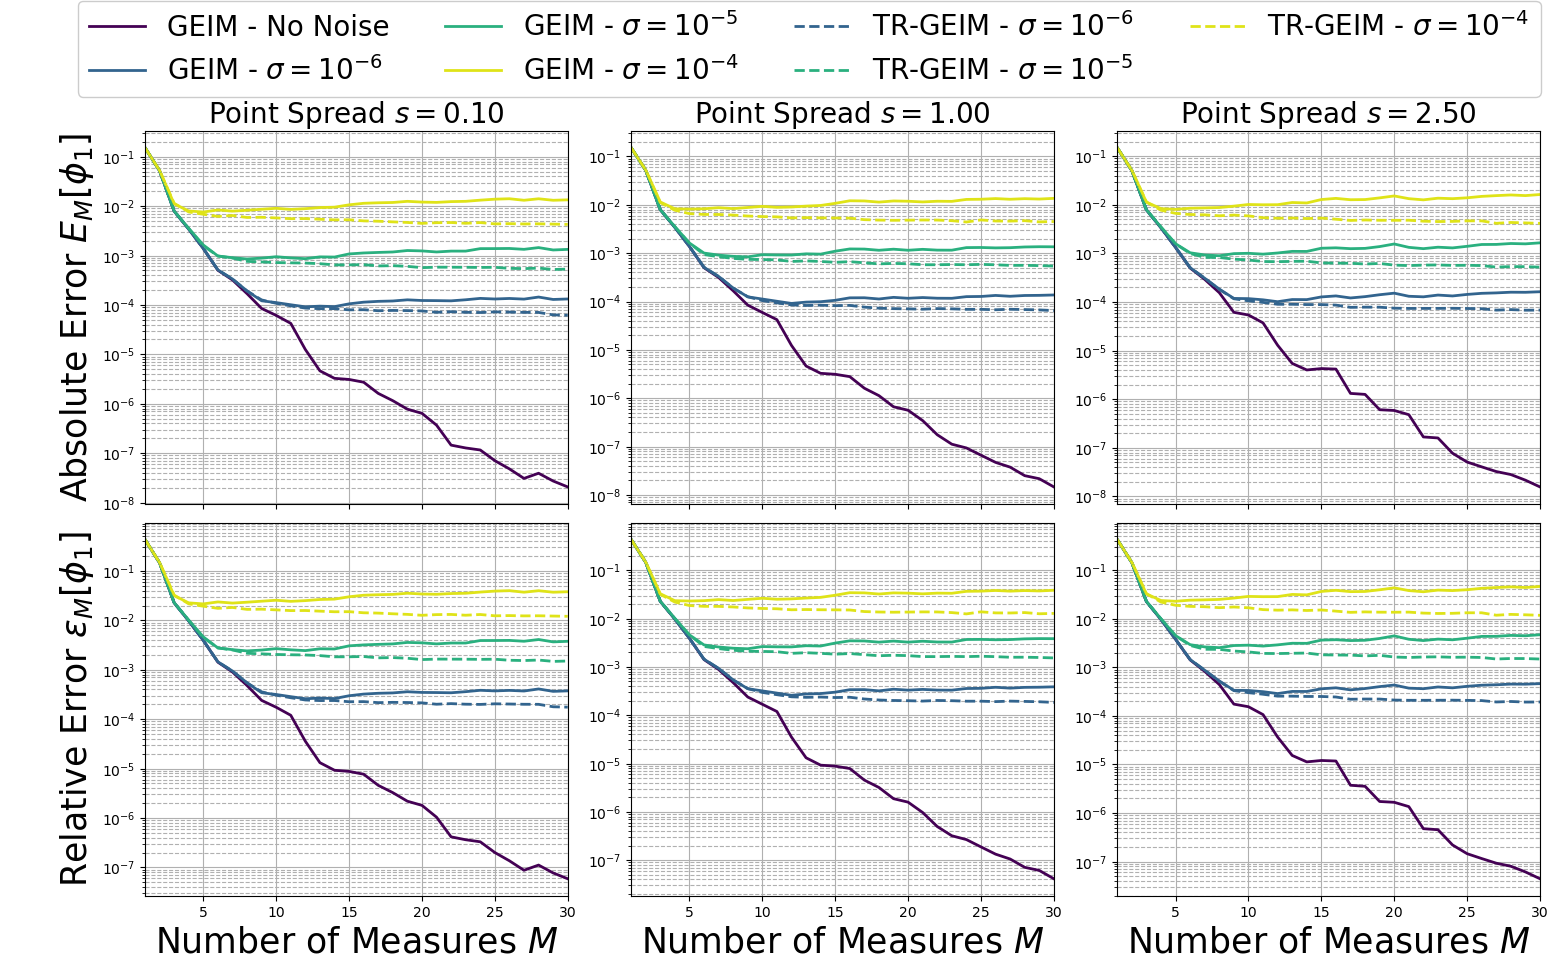

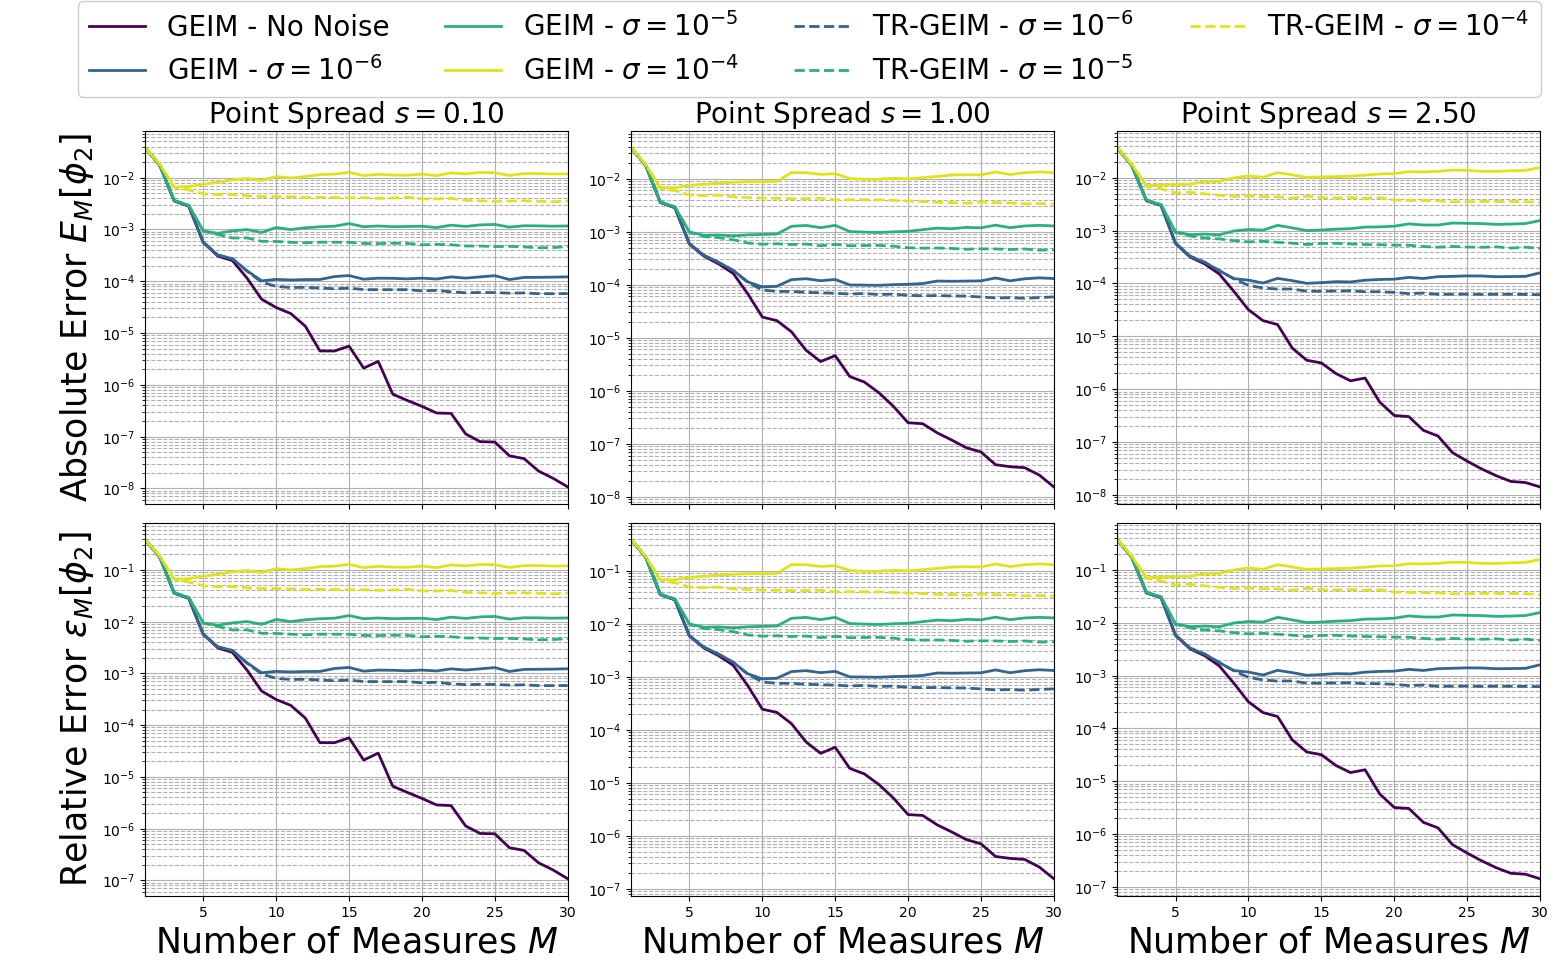

In [20]:
ls = 2
Mplot = np.arange(1, Mmax+1,1)

for field_i, field in enumerate(var_names):

    fig, axs = plt.subplots(nrows = 2, ncols = len(s), sharex = True, figsize = (6 * len(s), 5 * 2))

    for jj in range(len(s)):
        
        colors = cm.viridis(np.linspace(0.,.95,len(sigma)))
        
        for err in range(2):
            for idx_noise in range(len(sigma)):
                if sigma[idx_noise] is None:
                    label = r'No Noise'
                else:
                    label = r'$\sigma = 10^{'+str(int(np.log10(sigma[idx_noise])))+'}$'
                axs[err, jj].semilogy(Mplot, test_errors['geim'][field][jj][idx_noise][err],         linewidth=ls, c = colors[idx_noise], label = 'GEIM - '+label)
                
    for jj in range(len(s)):
        colors = cm.viridis(np.linspace(0.,.95,len(sigma)))
        for err in range(2):
            for idx_noise in range(len(sigma)):
                if sigma[idx_noise] is not None:
                    label = r'$\sigma = 10^{'+str(int(np.log10(sigma[idx_noise])))+'}$'
                    axs[err, jj].semilogy(Mplot, test_errors['trgeim'][field][jj][idx_noise - 1][err], '--', linewidth=ls, c = colors[idx_noise], label = 'TR-GEIM - '+label)
            axs[err, jj].grid(which = 'major', linestyle = '-')
            axs[err, jj].grid(which = 'minor', linestyle = '--')
            axs[err, jj].set_xlim(1, Mmax)
        axs[0, jj].set_title(r'Point Spread $s={:.2f}$'.format(s[jj]), fontsize=20)
            
        axs[1, jj].set_xlabel(r'Number of Measures $M$', fontsize=25)

    axs[0,0].set_ylabel(r'Absolute Error $E_M['+tex_var_names[field_i]+']$', fontsize=25)
    axs[1,0].set_ylabel(r'Relative Error $\epsilon_M['+tex_var_names[field_i]+']$', fontsize=25)
        
    Lines, Labels = axs[0,0].get_legend_handles_labels()

    fig.legend(Lines, Labels, framealpha=1, loc=(0.05, 0.9), ncols = len(sigma), fontsize=20)
    fig.subplots_adjust(hspace = 0.05, wspace = 0.15, top = 0.875)

In the end, let us plot the computational time required by the Online Phase.

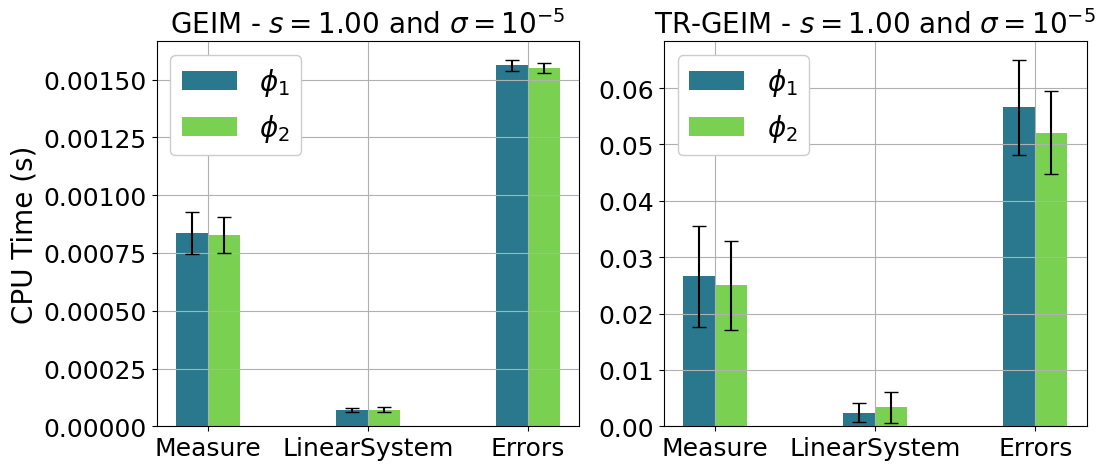

In [32]:
jj = 1
idx_noise = 2

# Initialize subplots
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 5))


for idx_ax in range(len(axs)):
    algo = list(comput_time.keys())[idx_ax]
    
    # Iterate over field_i values
    colors = plt.cm.viridis(np.linspace(0.4, 0.8, len(var_names)))  # Choose a colormap
    for field_i, color in zip(range(len(var_names)), colors):
        means = []
        stds = []
        field = var_names[field_i]

        # Calculate mean and std for each key
        for key in list(comput_time[algo][field][jj][idx_noise].keys()):
            mean = np.mean(np.mean(comput_time[algo][field][jj][idx_noise][key], axis=0))
            std = np.std(np.mean(comput_time[algo][field][jj][idx_noise][key], axis=0))
            means.append(mean)
            stds.append(std)

        # Plot the bar chart with error bars for standard deviation
        bar_width = 0.2  # Adjust as needed
        ind = np.arange(len(list(comput_time[algo][field][jj][idx_noise].keys())))
        bars = axs[idx_ax].bar(ind + (field_i - len(var_names) / 4) * bar_width, means, bar_width, label=r'$'+tex_var_names[field_i]+'$', color=color, yerr=stds, capsize=5)
    
    if idx_ax == 0:
        axs[idx_ax].set_ylabel(r'CPU Time (s)', fontsize=20)
        axs[idx_ax].set_title(r'GEIM - $s={:.2f}$'.format(s[jj])+' and $\sigma= 10^{'+str(int(np.log10(sigma[idx_noise])))+'}$', fontsize=20)
    else:
        axs[idx_ax].set_title(r'TR-GEIM - $s={:.2f}$'.format(s[jj])+' and $\sigma= 10^{'+str(int(np.log10(sigma[idx_noise])))+'}$', fontsize=20)
        
    axs[idx_ax].set_xticks(ind)
    axs[idx_ax].set_xticklabels(list(comput_time[algo][field][jj][idx_noise].keys()))
    axs[idx_ax].legend(framealpha=1, fontsize=20)
    axs[idx_ax].tick_params(axis='both', labelsize=18)
    axs[idx_ax].grid()

### Plotting the interpolant and the residual fields
Using *pyvista* and some additional functions the interpolant and its residual field $r[u] = | u - \mathcal{P}[u]|$ is plotted.

In [ ]:
import pandas as pd

import vtk
import pyvista as pv
import dolfinx

pv.start_xvfb()

In [70]:
def grids(fun: dolfinx.fem.Function):
    topology, cell_types, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    u_grid = pv.UnstructuredGrid(topology, cell_types, geometry)
    u_grid.point_data['fun'] = fun.x.array[:].real
    u_grid.set_active_scalars('fun')
    return u_grid

def PlotFOM_vs_ROM( fom: FunctionsList, rom: dict, mu: int, title: str, varname: str,
                    clim = None, colormap = cm.jet, 
                    colormap_res = cm.plasma_r, clim_res = None):  
    
    keys = list(rom.keys())
    
    resolution = [1200, 600 * ( len(keys) + 1)]
    plotter = pv.Plotter(shape=(len(keys)+1, 2), off_screen=False, border=False, window_size=resolution)
    
    lab_fontsize = 32
    title_fontsize = 40
    zoom = 1.05
    
    dict_cb = dict(title = varname, width = 0.75, height = 0.1,
                    title_font_size=title_fontsize,
                    label_font_size=lab_fontsize,
                    n_labels=3,
                    color = 'k',
                    position_x=0.125, position_y=0.8,
                    shadow=False) 
    
    ############################ FOMs ###################################

    plotter.subplot(0,0)
    
    warped_fom = grids(fom.map(mu))
    if clim is None:
        clim = [min(fom(mu)), max(fom(mu))]
    
    dict_cb['title'] = 'FOM - $'+varname+'$'
    plotter.add_mesh(warped_fom, clim = clim, cmap = colormap, show_edges=False, scalar_bar_args=dict_cb)
    plotter.view_xy()
    plotter.camera.zoom(zoom)

    ############################ ROMs ###################################


    for key_i in range(len(keys)):
        plotter.subplot(1+key_i,0)
    
        warped_rom = grids(rom[keys[key_i]].map(mu))
        
        dict_cb['title'] = keys[key_i]+' - $'+varname+'$'
        plotter.add_mesh(warped_rom, clim = clim, cmap = colormap, show_edges=False, scalar_bar_args=dict_cb)
        plotter.view_xy()
        plotter.camera.zoom(zoom)

    ############################ Residuals ###################################

    max_res = 0.
    for key_i in range(len(keys)):
        plotter.subplot(1+key_i,1)
        
        residual = dolfinx.fem.Function(rom[keys[key_i]].fun_space)
        residual.x.array[:] = np.abs(rom[keys[key_i]](mu) - fom(mu))

        max_res = max([max_res, max(residual.x.array[:])])
        
        warped_rom = grids(residual)
        
        if clim_res is None:
            clim_res = [0, max_res]
        
        dict_cb['title'] = 'Residual '+keys[key_i]+' - $'+varname+'$'
        plotter.add_mesh(warped_rom, clim = clim_res, cmap = colormap_res, show_edges=False, scalar_bar_args=dict_cb)
        plotter.view_xy()
        plotter.camera.zoom(zoom)


    plotter.set_background('white', top='white')
    plotter.subplot(0,1)
    plotter.add_text(str(title), color= 'k', position=[50, 300], font_size=25)

    ## Save figure
    plotter.show()

Let us reconstruct one of the fields for the whole test set, using some functions of the *GEIM* and *TR-GEIM* classes.

In [72]:
Mmax = 20

jj = 1
noise_value = 1e-4

rom_recs = list()

for field_i in range(len(var_names)):
    field = var_names[field_i]



    rom_recs.append({'GEIM': FunctionsList(V),
                    'TR-GEIM': FunctionsList(V)})

    for mu in range(len(test_snaps[field_i])):
        out_geim = geim_online[field][jj].reconstruct(test_snaps[field_i](mu), M = Mmax, noise_value = noise_value)
        rom_recs[field_i]['GEIM'].append(out_geim[0])

        out_trgeim = tr_geim_online[field][jj].reconstruct(test_snaps[field_i](mu), M = Mmax, noise_value = noise_value, reg_param = noise_value**2)
        rom_recs[field_i]['TR-GEIM'].append(out_trgeim[0])
        
        del out_geim, out_trgeim

Let us compare the fast and thermal flux with respect to some benchmark data.

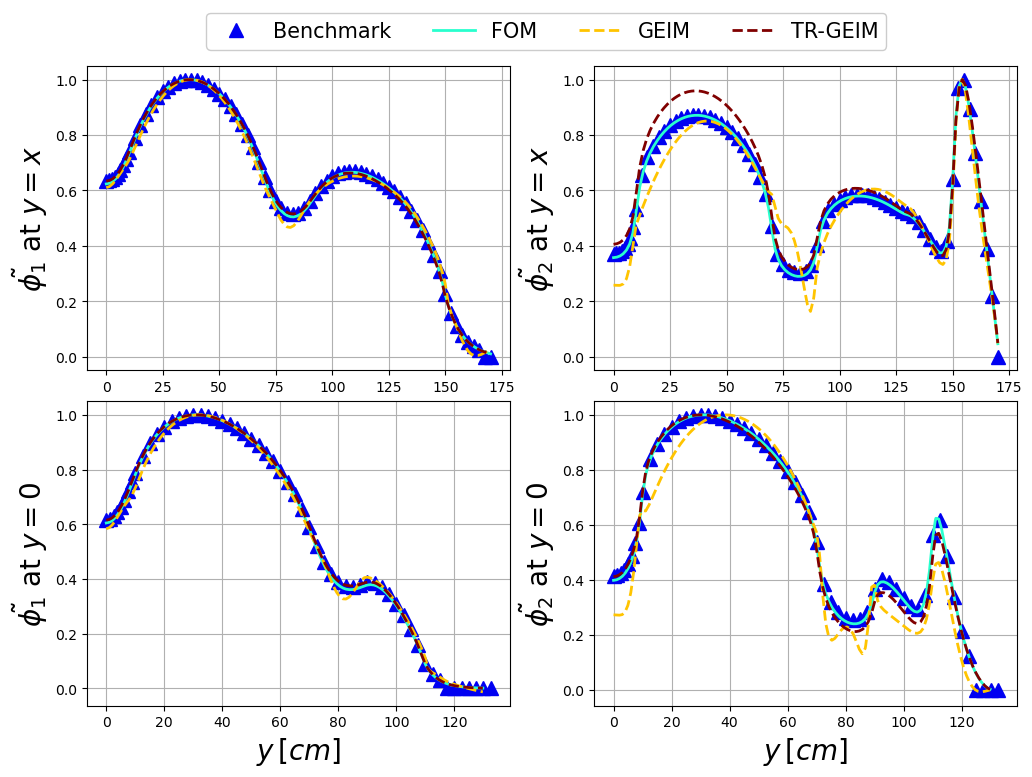

In [166]:
def extract_cells(domain, points):

    bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)
    cells = []
    points_on_proc = []
    cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
    colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, points.T)
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i))>0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])
    xPlot = np.array(points_on_proc, dtype=np.float64)

    return xPlot, cells

Nhplot = 1000
xMax = 170
x_line = np.linspace(0, xMax + 1e-20, Nhplot)
points = [np.zeros((3, Nhplot)), 
          np.zeros((3, Nhplot))]
points[0][0] = x_line
points[1][0] = x_line
points[1][1] = x_line

extracted = [extract_cells(domain, point) for point in points]

## Uploading data from benchmark

bench_path = '..//BenchmarkData/MGDiffusion_ANL11A2/anl11a2_data.xlsx'

bench_data = [pd.read_excel(bench_path, sheet_name='x-axis').to_numpy()/1000, 
              pd.read_excel(bench_path, sheet_name='Diagonal').to_numpy()/1000]

bench_labels = [r'$y=x$', r'$y=0$']

mark_size = 10
ls = 2
tickssize = 20

mu_bench = 220

fluxFigure, axs = plt.subplots(nrows = 2, ncols = len(var_names), figsize=(6 * len(var_names), 8))

for bench_i in range(2):
    xPlot = extracted[bench_i][0]
    cells = extracted[bench_i][1]
    for field_i in range(len(var_names)):
        colors = cm.jet(np.linspace(0.1,1, len(list(rom_recs[field_i].keys()))+2))
        axs[bench_i, field_i].plot(bench_data[bench_i][:, 0], bench_data[bench_i][:, field_i+bench_i+1] / max(bench_data[bench_i][:, field_i+bench_i+1]), '^', 
                                   c=colors[0], label = r'Benchmark', markersize=mark_size)
        axs[bench_i, field_i].plot(xPlot[:,0], test_snaps[field_i].map(mu_bench).eval(xPlot, cells) / max(test_snaps[field_i].map(mu_bench).eval(xPlot, cells)),
                                   c=colors[1], label = r'FOM', linewidth=ls)
        
        for algo_i, algo in enumerate(list(rom_recs[field_i].keys())):
            axs[bench_i, field_i].plot(xPlot[:,0], rom_recs[field_i][algo].map(mu_bench).eval(xPlot, cells) / max(rom_recs[field_i][algo].map(mu_bench).eval(xPlot, cells)),
                                       '--', c=colors[2+algo_i], label = algo, linewidth=ls)
            

        axs[bench_i, field_i].grid(which='major',linestyle='-')
        axs[bench_i, field_i].grid(which='minor',linestyle='--')
        axs[bench_i, field_i].set_ylabel(r"$\tilde{"+tex_var_names[field_i]+"}$ at "+bench_labels[bench_i], fontsize=20)
        
        if bench_i + 1 == 2:
            axs[bench_i, field_i].set_xlabel(r"$y\,[cm]$",fontsize=20)    
        
Lines, Labels = axs[0,0].get_legend_handles_labels()
fluxFigure.legend(Lines, Labels, framealpha=1, loc=(0.2, 0.935), ncols = 2+len(rom_recs[0]), fontsize=15)
fluxFigure.subplots_adjust(wspace=0.2, hspace=0.1, top = 0.91)

Let us make some contour plots

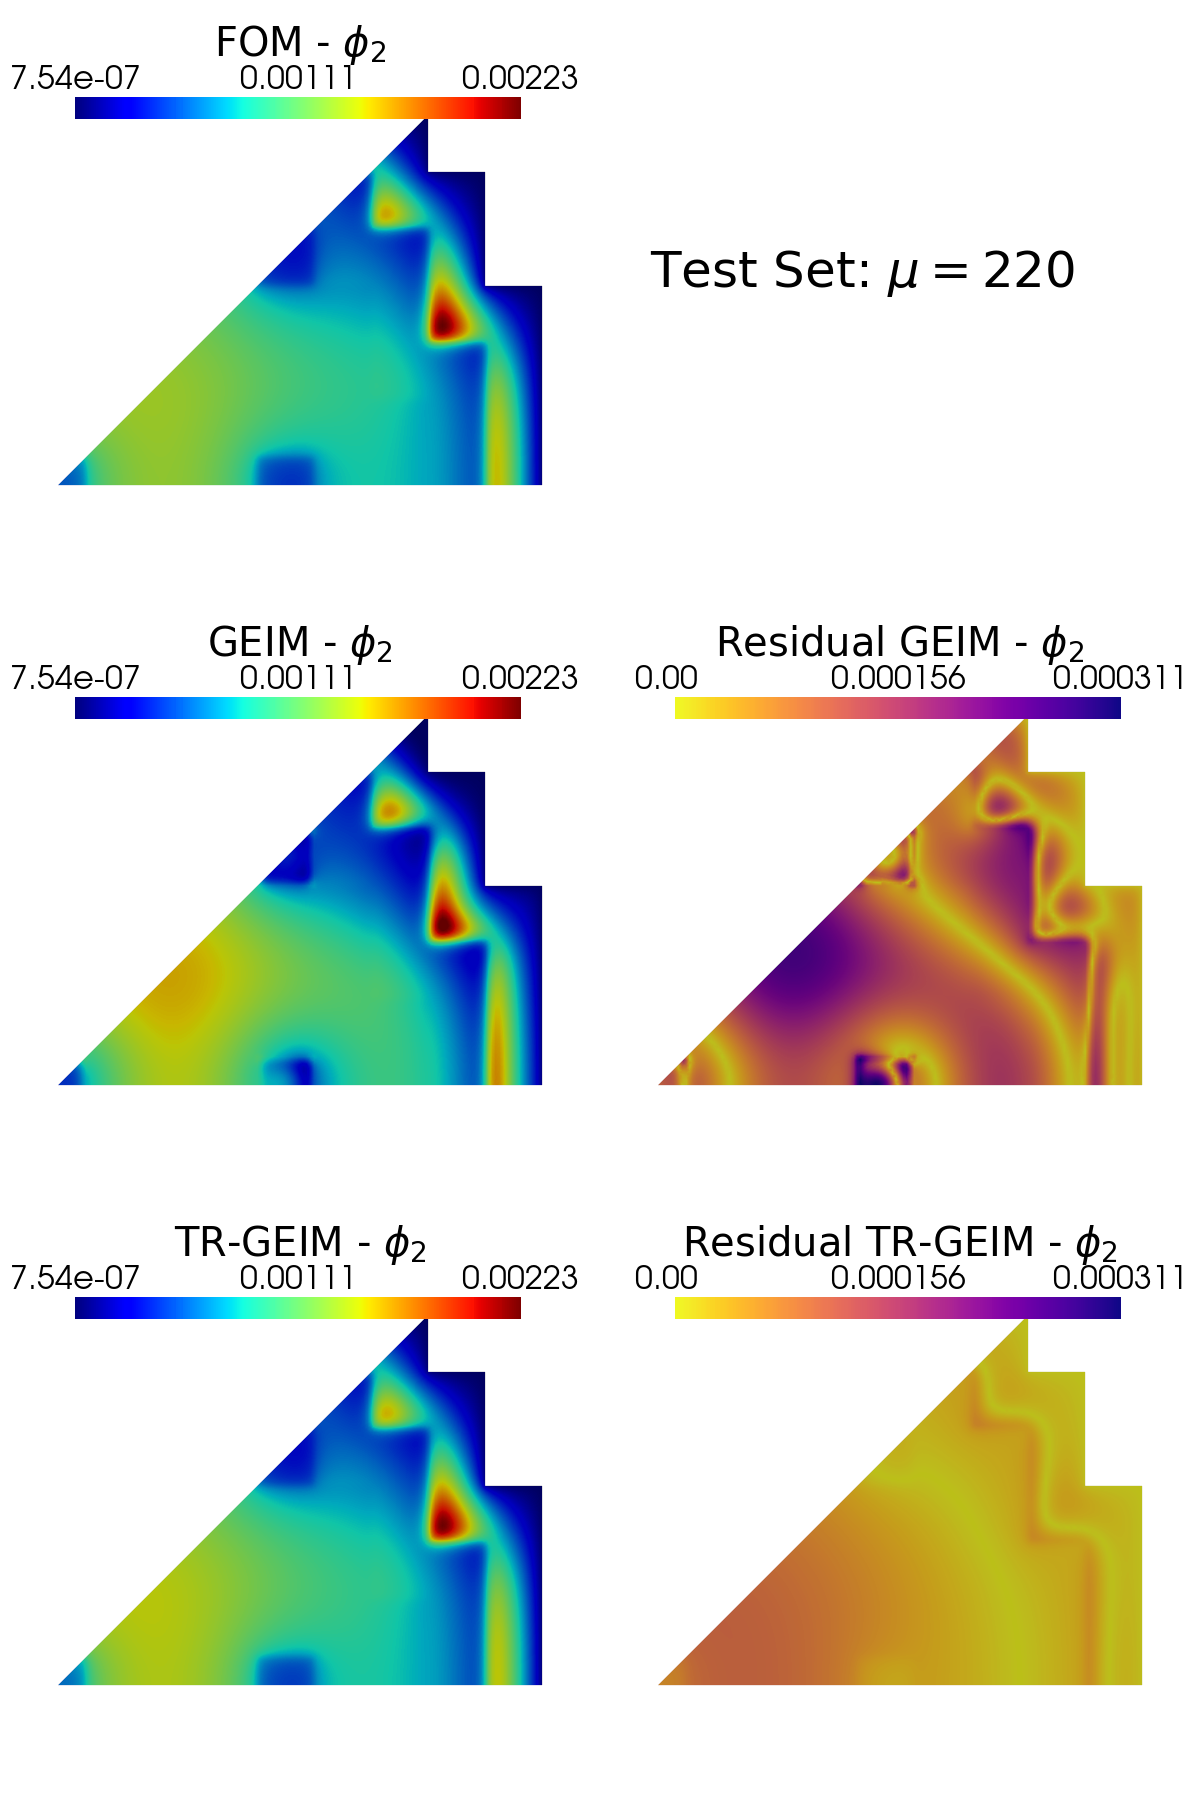

In [168]:
field_i = 1

PlotFOM_vs_ROM(test_snaps[field_i], rom_recs[field_i], mu = mu_bench, title='Test Set: $\mu = '+str(mu)+'$',
               varname=tex_var_names[field_i])